## About the Dataset
> * MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision.   
> * Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. 
> * As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

## Task
> * To correctly identify digits from a dataset of tens of thousands of handwritten images in the test dataset

# Libraries

In [1]:
# for numerical analysis
import numpy as np 
# to store and process in a dataframe
import pandas as pd 

# for ploting graphs
import matplotlib.pyplot as plt
# advancec ploting
import seaborn as sns

# image processing
import matplotlib.image as mpimg

# train test split
from sklearn.model_selection import train_test_split
# model performance metrics
from sklearn.metrics import confusion_matrix, classification_report

# utility functions
from tensorflow.keras.utils import to_categorical
# sequential model
from tensorflow.keras.models import Sequential
# layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


# from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ReduceLROnPlateau

# Data

In [2]:
# list of files
! ls ../input/digit-recognizer

sample_submission.csv  test.csv  train.csv


In [3]:
# import train and test dataset
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [4]:
# training dataset
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# test dataset
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# looking for missing values
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


# EDA

### Label count

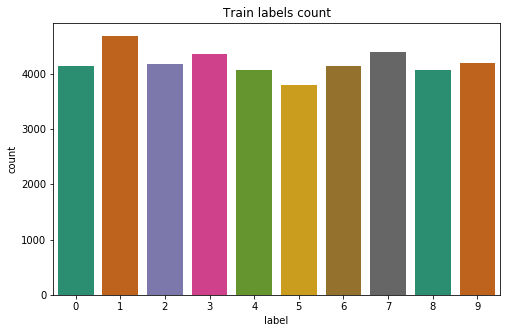

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(train['label'], palette='Dark2')
plt.title('Train labels count')
plt.show()

In [8]:
train['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

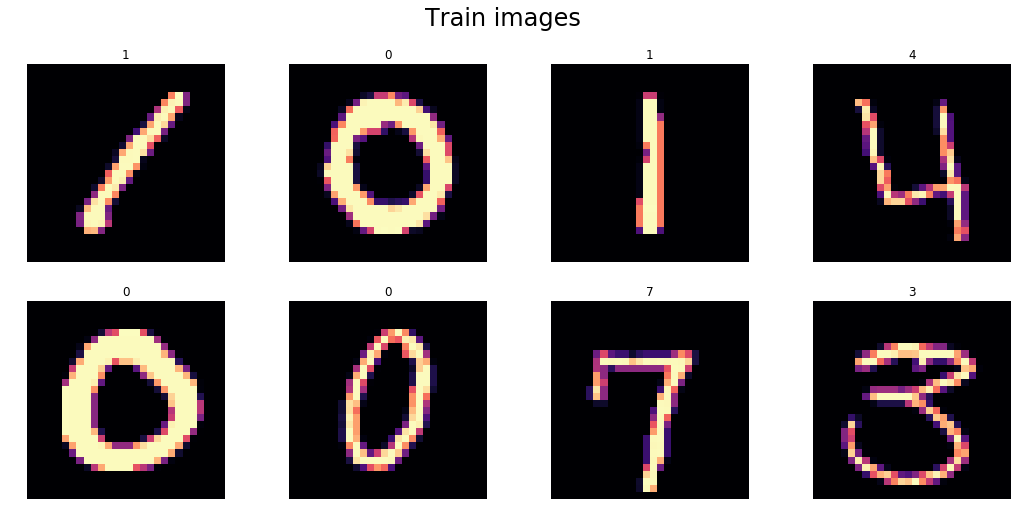

In [10]:
# first few train images with labels
fig, ax = plt.subplots(figsize=(18, 8))
for ind, row in train.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    plt.title(row[0])
    img = row.to_numpy()[1:].reshape(28, 28)
    fig.suptitle('Train images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')

> Test images doesn't have labels  
> We need to create a model to predict them

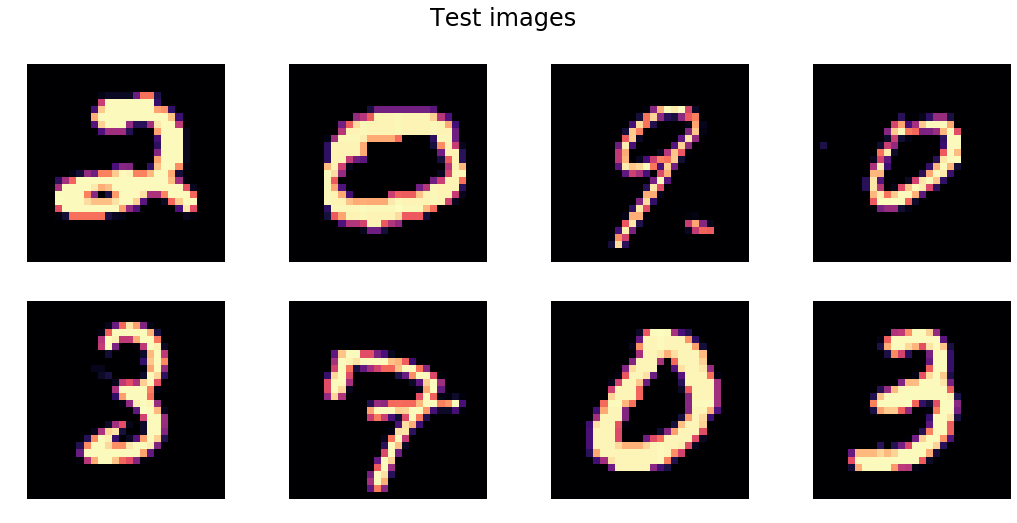

In [11]:
# first few test images
fig, ax = plt.subplots(figsize=(18, 8))
for ind, row in test.iloc[:8, :].iterrows():
    plt.subplot(2, 4, ind+1)
    img = row.to_numpy()[:].reshape(28, 28)
    fig.suptitle('Test images', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='magma')

# Preprocessing

In [12]:
# split into image and labels and convert to numpy array
X = train.iloc[:, 1:].to_numpy()
y = train['label'].to_numpy()

# test dataset
test = test.loc[:, :].to_numpy()

for i in [X, y, test]:
    print(i.shape)

(42000, 784)
(42000,)
(28000, 784)


In [13]:
# normalize the data
# ==================

X = X / 255.0
test = test / 255.0

In [14]:
# reshape dataset
# ===============

# shape of training and test dataset
print(X.shape)
print(test.shape)

# reshape the dataframe to 3x3 matrix with 1 channel grey scale values
X = X.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

# shape of training and test dataset
print(X.shape)
print(test.shape)

(42000, 784)
(28000, 784)
(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [15]:
# one hot encode target
# =====================

# shape and values of target
print(y.shape)
print(y[0])

# convert Y_train to categorical by one-hot-encoding
y_enc = to_categorical(y, num_classes = 10)

# shape and values of target
print(y_enc.shape)
print(y_enc[0])

(42000,)
1
(42000, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
# train test split
# ================

# random seed
random_seed = 2

# train validation split
X_train, X_val, y_train_enc, y_val_enc = train_test_split(X, y_enc, test_size=0.3)

# shape
for i in [X_train, y_train_enc, X_val, y_val_enc]:
    print(i.shape)

(29400, 28, 28, 1)
(29400, 10)
(12600, 28, 28, 1)
(12600, 10)


## Plot images

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


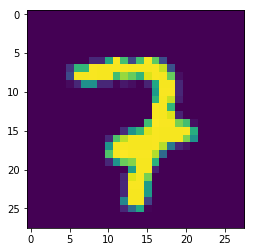

In [17]:
g = plt.imshow(X_train[0][:,:,0])
print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


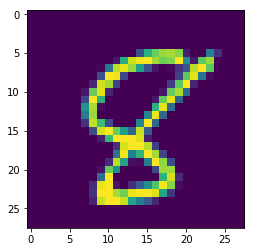

In [18]:
g = plt.imshow(X_train[9][:,:,0])
print(y_train_enc[9])

# CNN

### Model parameters

In [21]:
INPUT_SHAPE = (28,28,1)
OUTPUT_SHAPE = 10
BATCH_SIZE = 128
EPOCHS = 10
VERBOSE = 2

### Define CNN Model

In [23]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

### Compile model

In [24]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Model summary

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

### Model fitting

In [26]:
history = model.fit(X_train, y_train_enc,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=VERBOSE,
                    validation_split=0.3)

Train on 20580 samples, validate on 8820 samples
Epoch 1/10
20580/20580 - 11s - loss: 0.5979 - accuracy: 0.8058 - val_loss: 0.1179 - val_accuracy: 0.9636
Epoch 2/10
20580/20580 - 10s - loss: 0.1477 - accuracy: 0.9546 - val_loss: 0.0786 - val_accuracy: 0.9748
Epoch 3/10
20580/20580 - 10s - loss: 0.0988 - accuracy: 0.9706 - val_loss: 0.0644 - val_accuracy: 0.9794
Epoch 4/10
20580/20580 - 10s - loss: 0.0707 - accuracy: 0.9787 - val_loss: 0.0587 - val_accuracy: 0.9808
Epoch 5/10
20580/20580 - 10s - loss: 0.0620 - accuracy: 0.9810 - val_loss: 0.0502 - val_accuracy: 0.9841
Epoch 6/10
20580/20580 - 11s - loss: 0.0485 - accuracy: 0.9850 - val_loss: 0.0468 - val_accuracy: 0.9854
Epoch 7/10
20580/20580 - 10s - loss: 0.0423 - accuracy: 0.9884 - val_loss: 0.0454 - val_accuracy: 0.9853
Epoch 8/10
20580/20580 - 10s - loss: 0.0376 - accuracy: 0.9886 - val_loss: 0.0440 - val_accuracy: 0.9876
Epoch 9/10
20580/20580 - 10s - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0573 - val_accuracy: 0.9836
Epoch 

### Accurayc and loss

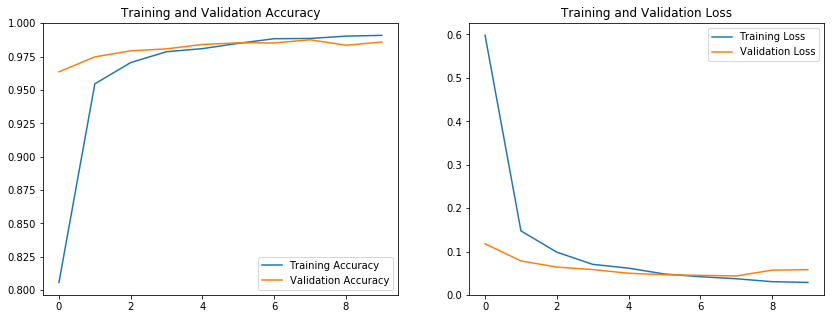

In [27]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

### Evaluating on validationa dataset

In [28]:
# model loss and accuracy on validation set
model.evaluate(X_val, y_val_enc, verbose=False)

[0.05724667683323672, 0.984127]

In [29]:
# predicted values
y_pred_enc = model.predict(X_val)

# actual
y_act = [np.argmax(i) for i in y_val_enc]

# decoding predicted values
y_pred = [np.argmax(i) for i in y_pred_enc]

print(y_pred_enc[0])
print(y_pred[0])

[9.9977211e-04 6.4189365e-04 9.9294031e-01 1.6193405e-03 9.8092481e-05
 5.8917090e-06 7.3003316e-06 3.5417462e-03 9.1248447e-05 5.4369004e-05]
2


In [30]:
print(classification_report(y_act, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1254
           1       0.98      1.00      0.99      1356
           2       0.99      0.96      0.98      1233
           3       0.99      0.98      0.99      1329
           4       0.99      0.98      0.98      1227
           5       0.99      0.97      0.98      1149
           6       0.98      1.00      0.99      1270
           7       0.98      0.98      0.98      1283
           8       0.99      0.98      0.98      1262
           9       0.96      0.99      0.97      1237

    accuracy                           0.98     12600
   macro avg       0.98      0.98      0.98     12600
weighted avg       0.98      0.98      0.98     12600



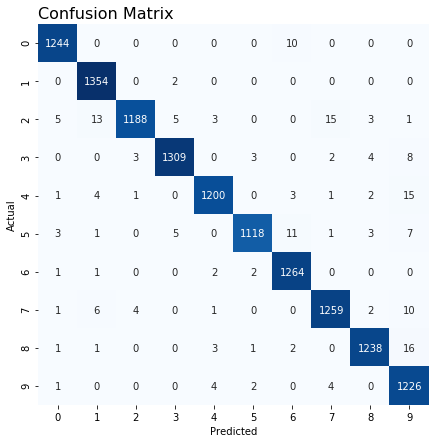

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(y_act, y_pred), annot=True, 
            cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', loc='left', fontsize=16)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Predicting on test

In [32]:
# predicted values
y_pred_enc = model.predict(test)

# decoding predicted values
y_pred = [np.argmax(i) for i in y_pred_enc]

print(y_pred_enc[0])
print(y_pred[0])

[6.1982712e-07 1.3033327e-08 9.9999607e-01 3.7705487e-08 5.3029612e-09
 5.1110987e-11 3.8376934e-11 3.3070264e-06 1.4779536e-09 6.7632872e-10]
2


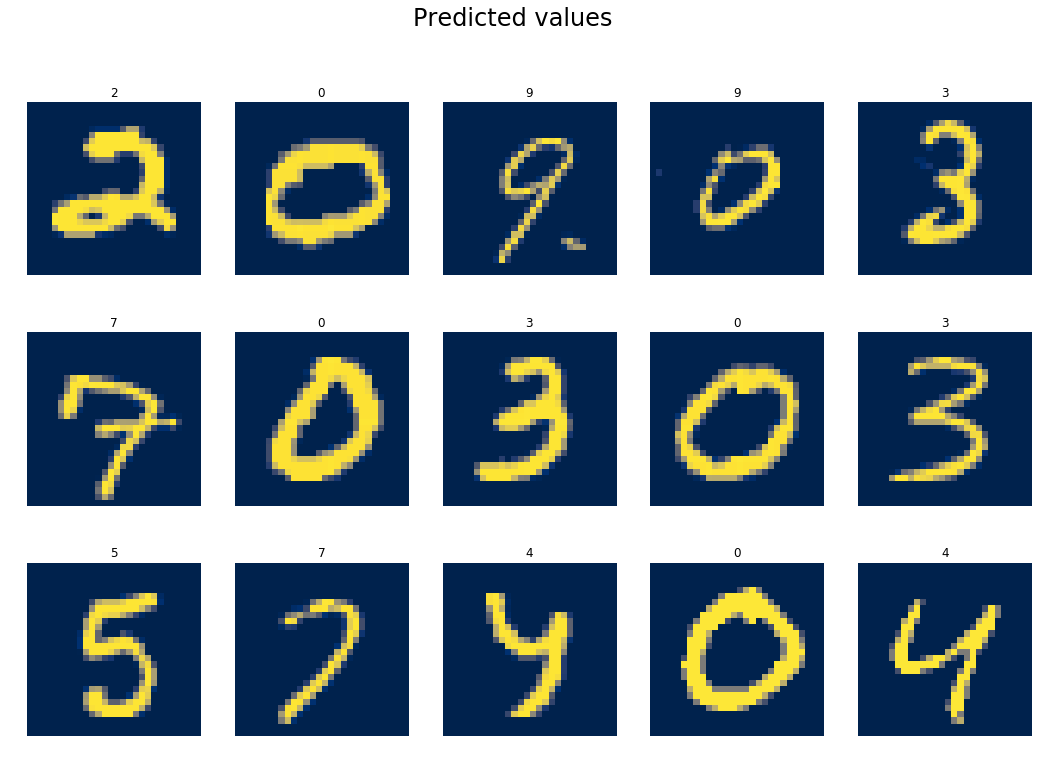

In [33]:
# predicted targets of each images
# (labels above the images are predicted labels)
fig, ax = plt.subplots(figsize=(18, 12))
for ind, row in enumerate(test[:15]):
    plt.subplot(3, 5, ind+1)
    plt.title(y_pred[ind])
    img = row.reshape(28, 28)
    fig.suptitle('Predicted values', fontsize=24)
    plt.axis('off')
    plt.imshow(img, cmap='cividis')

In [ ]:
# X_train, X_val, y_train_enc, y_val_enc